<a href="https://colab.research.google.com/github/katterine2558/palette-clustering/blob/main/SOLUCI%C3%93N_MEAN_SHIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOLUCIÓN MICROPROYECTO 1

Por: *Leonardo Almanza y Katerine Arias*

## 1. Importar librerías

En esta etapa inicial se realiza la importación de librerías, un paso fundamental para disponer de todas las herramientas necesarias en el proyecto. Se incluyen librerías de manipulación y análisis de datos (NumPy, Pandas), visualización (Matplotlib, Seaborn), procesamiento y reducción de dimensionalidad (scikit-learn, PCA, t-SNE), así como utilidades para el manejo de imágenes (OpenCV). Estas librerías permiten aplicar técnicas de machine learning no supervisado, como K-Means, con el fin de identificar y agrupar colores predominantes en las imágenes. De esta forma, se facilita la generación automática de paletas de colores representativas, que pueden aplicarse en áreas como diseño gráfico, análisis de estilo visual y visión por computador.

In [5]:
# Importa librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import cv2
from sklearn.base import BaseEstimator, TransformerMixin
from PIL import Image as PILImage

## 2. Recopilación de imagenes

En esta etapa se seleccionaron 8 imágenes de artes variados del dataset [WikiArt](https://https://www.kaggle.com/datasets/steubk/wikiart), con el fin de representar un amplio espectro de colores. Estas imágenes se organizaron en un diccionario y se visualizaron en grilla para su verificación previa al análisis.

In [6]:
# Diccionario con nombre de imagenes
imgs_dict = {'image1': 'imgs/a.y.-jackson_smart-river-alaska-1945.jpg',
             'image2': 'imgs/abraham-manievich_camden-1923.jpg',
             'image3':'imgs/adriaen-brouwer_farmers-fight-party.jpg',
             'image4':'imgs/aldemir-martins_baiana-1980.jpg',
             'image5': 'imgs/allen-jones_crazy-horse-1976.jpg',
             'image6': 'imgs/andy-warhol_arnold-schwarzenegger-1977.jpg',
             'image7':'imgs/giorgio-vasari_boccaccio-dante-petrarca.jpg',
             'image8':'imgs/hiroshige_bay-at-kominato-in-awa-province.jpg'}

In [7]:
#Plotea imagenes seleccionadas
def plot_images_grid(image_paths, grid_size=(2, 4), figsize=(10, 8)):
    """
    Plotea las imagenes en grilla.
    Input args:
        image_paths (list): Lista de rutas a las imágenes.
        grid_size (tuple): Tamaño de la grilla (filas, columnas).
        figsize (tuple): Tamaño de la figura.
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    axes = axes.flatten()

    for i, img_path in enumerate(image_paths):
        if i < len(axes):
            try:
                img = PILImage.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(f"Image {i+1}")
                axes[i].axis('off')
            except FileNotFoundError:
                axes[i].set_title(f"Image {i+1} not found")
                axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

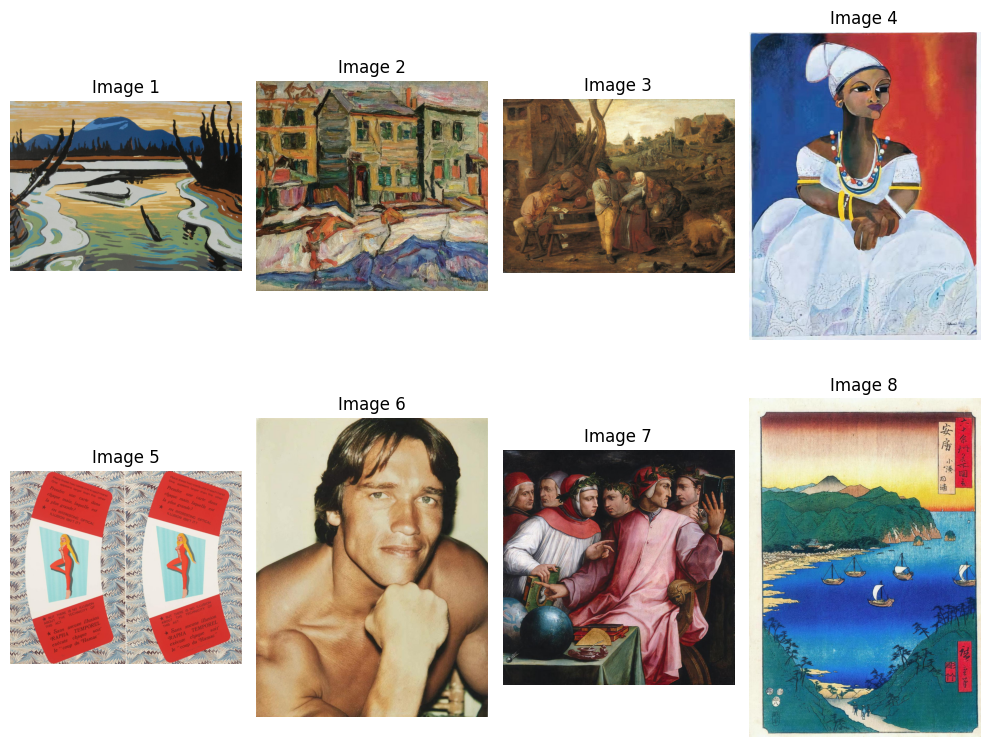

In [8]:
# Plot de imagenes
image_paths_list = list(imgs_dict.values())
plot_images_grid(image_paths_list)

##3. Preparación de los datos
La preparación de los datos es crucial antes de aplicar un algoritmo, especialmente con imágenes y en entornos no supervisados: estandariza las entradas, reduce ruido y estabiliza el espacio donde se comparan colores, evitando sesgos y mejorando la convergencia y la interpretabilidad de los resultados. Es por esto que se implementarán clases de preparación, las cuales se integrarán al pipeline para garantizar datos consistentes, comparables y listos para el algoritmo de agrupamiento.

### 3.1. Clase Image

La clase `Image` funciona como un contenedor ligero de estado: inicia con `image=None` y almacena la matriz de la imagen a medida que avanza el proceso. Así, los transformadores del pipeline pueden compartir y actualizar la misma referencia (p. ej., la versión RGB ya cargada) sin releer el archivo ni duplicar datos innecesariamente.

In [9]:
#Obtiene la imagen
class Image:
  def __init__(self):
      self.image = None

### 3.2. Clase ImageReader

`ImageReader` es un transformador compatible con `scikit-learn` que se encarga de cargar la imagen desde una ruta usando `cv2.imread`. Mantiene el contrato de un pipeline (fit sin aprendizaje y transform que realiza la acción) y devuelve la matriz de la imagen (ndarray en BGR) lista para las siguientes etapas. El parámetro image permite integrarse con el estado compartido del flujo, aunque en este paso solo realiza la lectura.

In [10]:
#Carga la imagen
class ImageReader(BaseEstimator, TransformerMixin):
  def __init__(self, image):
    self.image = image

  def fit(self, X, y=None):
    return self

  def transform(self, path):
    img = cv2.imread(path)
    return img